In this code, we map the seasonal regional differences in sea ice concentration between CS2, NASA Team, and the Canadian Ice Service.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import glob
import pandas as pd
import os
import cartopy
import cartopy.crs as ccrs
import scipy
from scipy import stats
import geopandas as gpd
from shapely.prepared import prep
from shapely.geometry import Point
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def transform_coords(lon, lat, projection):
    x, y = projection.transform_point(lon, lat, ccrs.PlateCarree())
    return x, y

def calculating_seasonal_means(source_directory,months,years,SIC_DataType):
    all_array = []
    for month in months:
        for year in years:
            plotting_array = np.load(source_directory+str(year)+str(month)+SIC_DataType+'.npy')
            all_array.append(plotting_array)  
            
    stacked_array = np.stack(all_array,axis=0)
    mean_array = np.nanmean(stacked_array,axis=0)
    std_array = np.nanstd(stacked_array,axis=0)

    return(mean_array,std_array)

def plotting_diff_maps_grid(map_projection, new_x, new_y, data,vmin, vmax, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': map_projection})
    else:
        fig = ax.figure
    
    ax.coastlines(linewidth=0.2,zorder=2)
    ax.set_extent([x_min, x_max, y_min, y_max], crs=map_projection)
    ax.add_feature(cartopy.feature.LAND, color='gainsboro', zorder=1)
    
    add_shapefile_to_plot(ax, bs_shp, color='none',edgecolor='IndianRed', linewidth=1.5)
    add_shapefile_to_plot(ax, bb_shp, color='none', edgecolor='IndianRed', linewidth=1.5)
    
    pcm = ax.pcolormesh(new_x, new_y, data, cmap=cmap, transform=map_projection, vmin=vmin, vmax=vmax,zorder=0)
    
    return pcm

def add_shapefile_to_plot(ax, gdf,color,edgecolor, linewidth):
    for geom in gdf.geometry:
        ax.add_geometries([geom], crs=map_projection, facecolor=color,edgecolor=edgecolor, linewidth=linewidth)

Centre grid shape =  (58, 131)
Edges grid shape =  (59, 132)


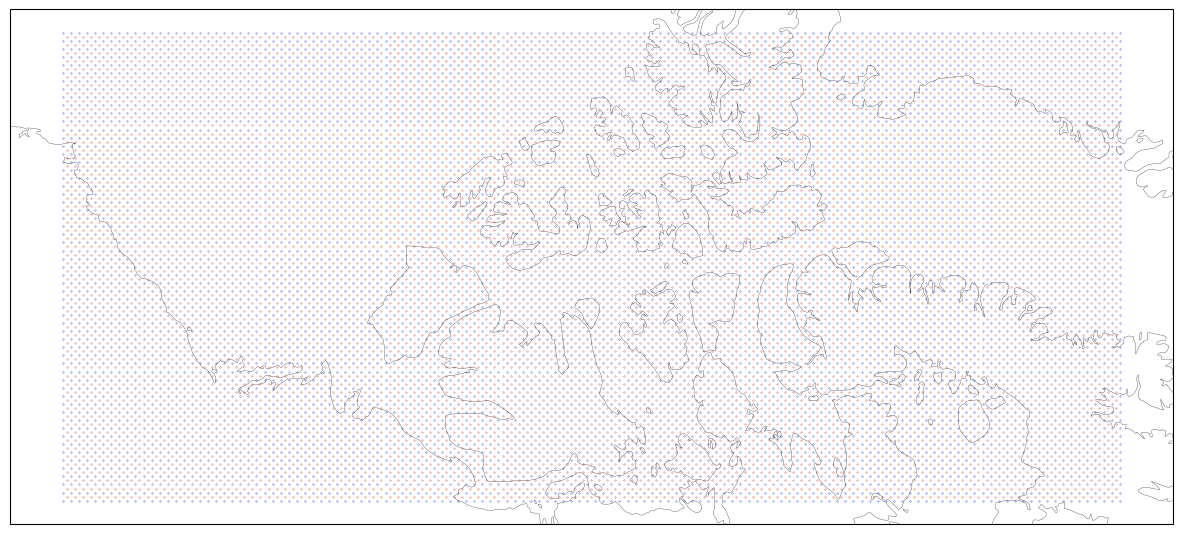

In [3]:
# Define the custom Lambert Azimuthal Equal Area projection
map_projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-105,central_latitude=74)

# Coordinates to transform (lon, lat) in the Plate Carree projection
geo_extent = [-140, -70, 64, 79]

# Get corners of 'bounding box' from geo_extent
corners = [
    (geo_extent[0], geo_extent[2]),  # SW corner
    (geo_extent[1], geo_extent[2]),  # SE corner
    (geo_extent[0], geo_extent[3]),  # NW corner
    (geo_extent[1], geo_extent[3])   # NE corner
]

# Transform coordinates to the desired map area
proj_corners = [transform_coords(lon, lat, map_projection) for lon, lat in corners]
x_coords, y_coords = zip(*proj_corners)

x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

grid_spacing = 25000 # 25 km

x_grid_centre = np.arange(x_min-grid_spacing/2,x_max + grid_spacing/2, grid_spacing)
y_grid_centre = np.arange(y_min-grid_spacing/2,y_max + grid_spacing/2, grid_spacing)
new_x_centre, new_y_centre = np.meshgrid(x_grid_centre, y_grid_centre) # For PMV & CIS data (regridded)

x_grid_edge = np.arange(x_min-grid_spacing,x_max + grid_spacing, grid_spacing)
y_grid_edge = np.arange(y_min-grid_spacing,y_max + grid_spacing, grid_spacing)
new_x_edge, new_y_edge= np.meshgrid(x_grid_edge, y_grid_edge) # For CS2 data (gridded)

print('Centre grid shape = ',np.shape(new_x_centre)) 
print('Edges grid shape = ',np.shape(new_x_edge)) # edges should be one greater than centres

# Set up the figure
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=map_projection)
ax.coastlines(linewidth=0.2)
ax.scatter(new_x_centre,new_y_centre,0.05, color='red')
ax.scatter(new_x_edge,new_y_edge,0.05, color='blue')
plt.show()

In [4]:
# First, outline the directories and datatypes for the functions

team_source_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/PMV/')
team_datatype = '_Gridded_PMV_SIC'

cs2_source_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/Corrected/')
cs2_datatype = '_Corrected_CS2_SIC_Regrid'

cis_source_directory = ('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/CIS_Averaged_Arrays_Monthly/')
cis_datatype = '_Mean_CIS_SIC'

In [5]:
years = range(2011,2024)
years_cis = range(2011,2023)

autumn = ['10','11']
winter = ['12','01']
early_spring = ['02','03']
late_spring = ['04','05']

# Define seasons
seasons = {'Autumn': autumn, 'Winter': winter, 'Early-Spring': early_spring, 'Late-Spring': late_spring}
      
teamcs2_regions_diffs, ciscs2_regions_diffs, teamcis_regions_diffs = {},{},{}

for season_name, season_data in seasons.items():
    cs2_array,cs2_std = calculating_seasonal_means(cs2_source_directory, season_data,years,cs2_datatype)

    team_array,team_std = calculating_seasonal_means(team_source_directory, season_data,years,team_datatype)

    cis_array,cis_std = calculating_seasonal_means(cis_source_directory, season_data,years_cis,cis_datatype)

    teamcs2_regions_diffs[season_name] = team_array - cs2_array
    ciscs2_regions_diffs[season_name] = cis_array - cs2_array
    teamcis_regions_diffs[season_name] = team_array - cis_array

/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_94302/946237739.py:13: RuntimeWarning: Mean of empty slice
  mean_array = np.nanmean(stacked_array,axis=0)
/Users/amyswiggs/anaconda3/envs/map_myenv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [6]:
# Import shapefiles of the desired regions
bs_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BeaufortSea_Shapefile.shp')
bb_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BaffinBay_Shapefile.shp')


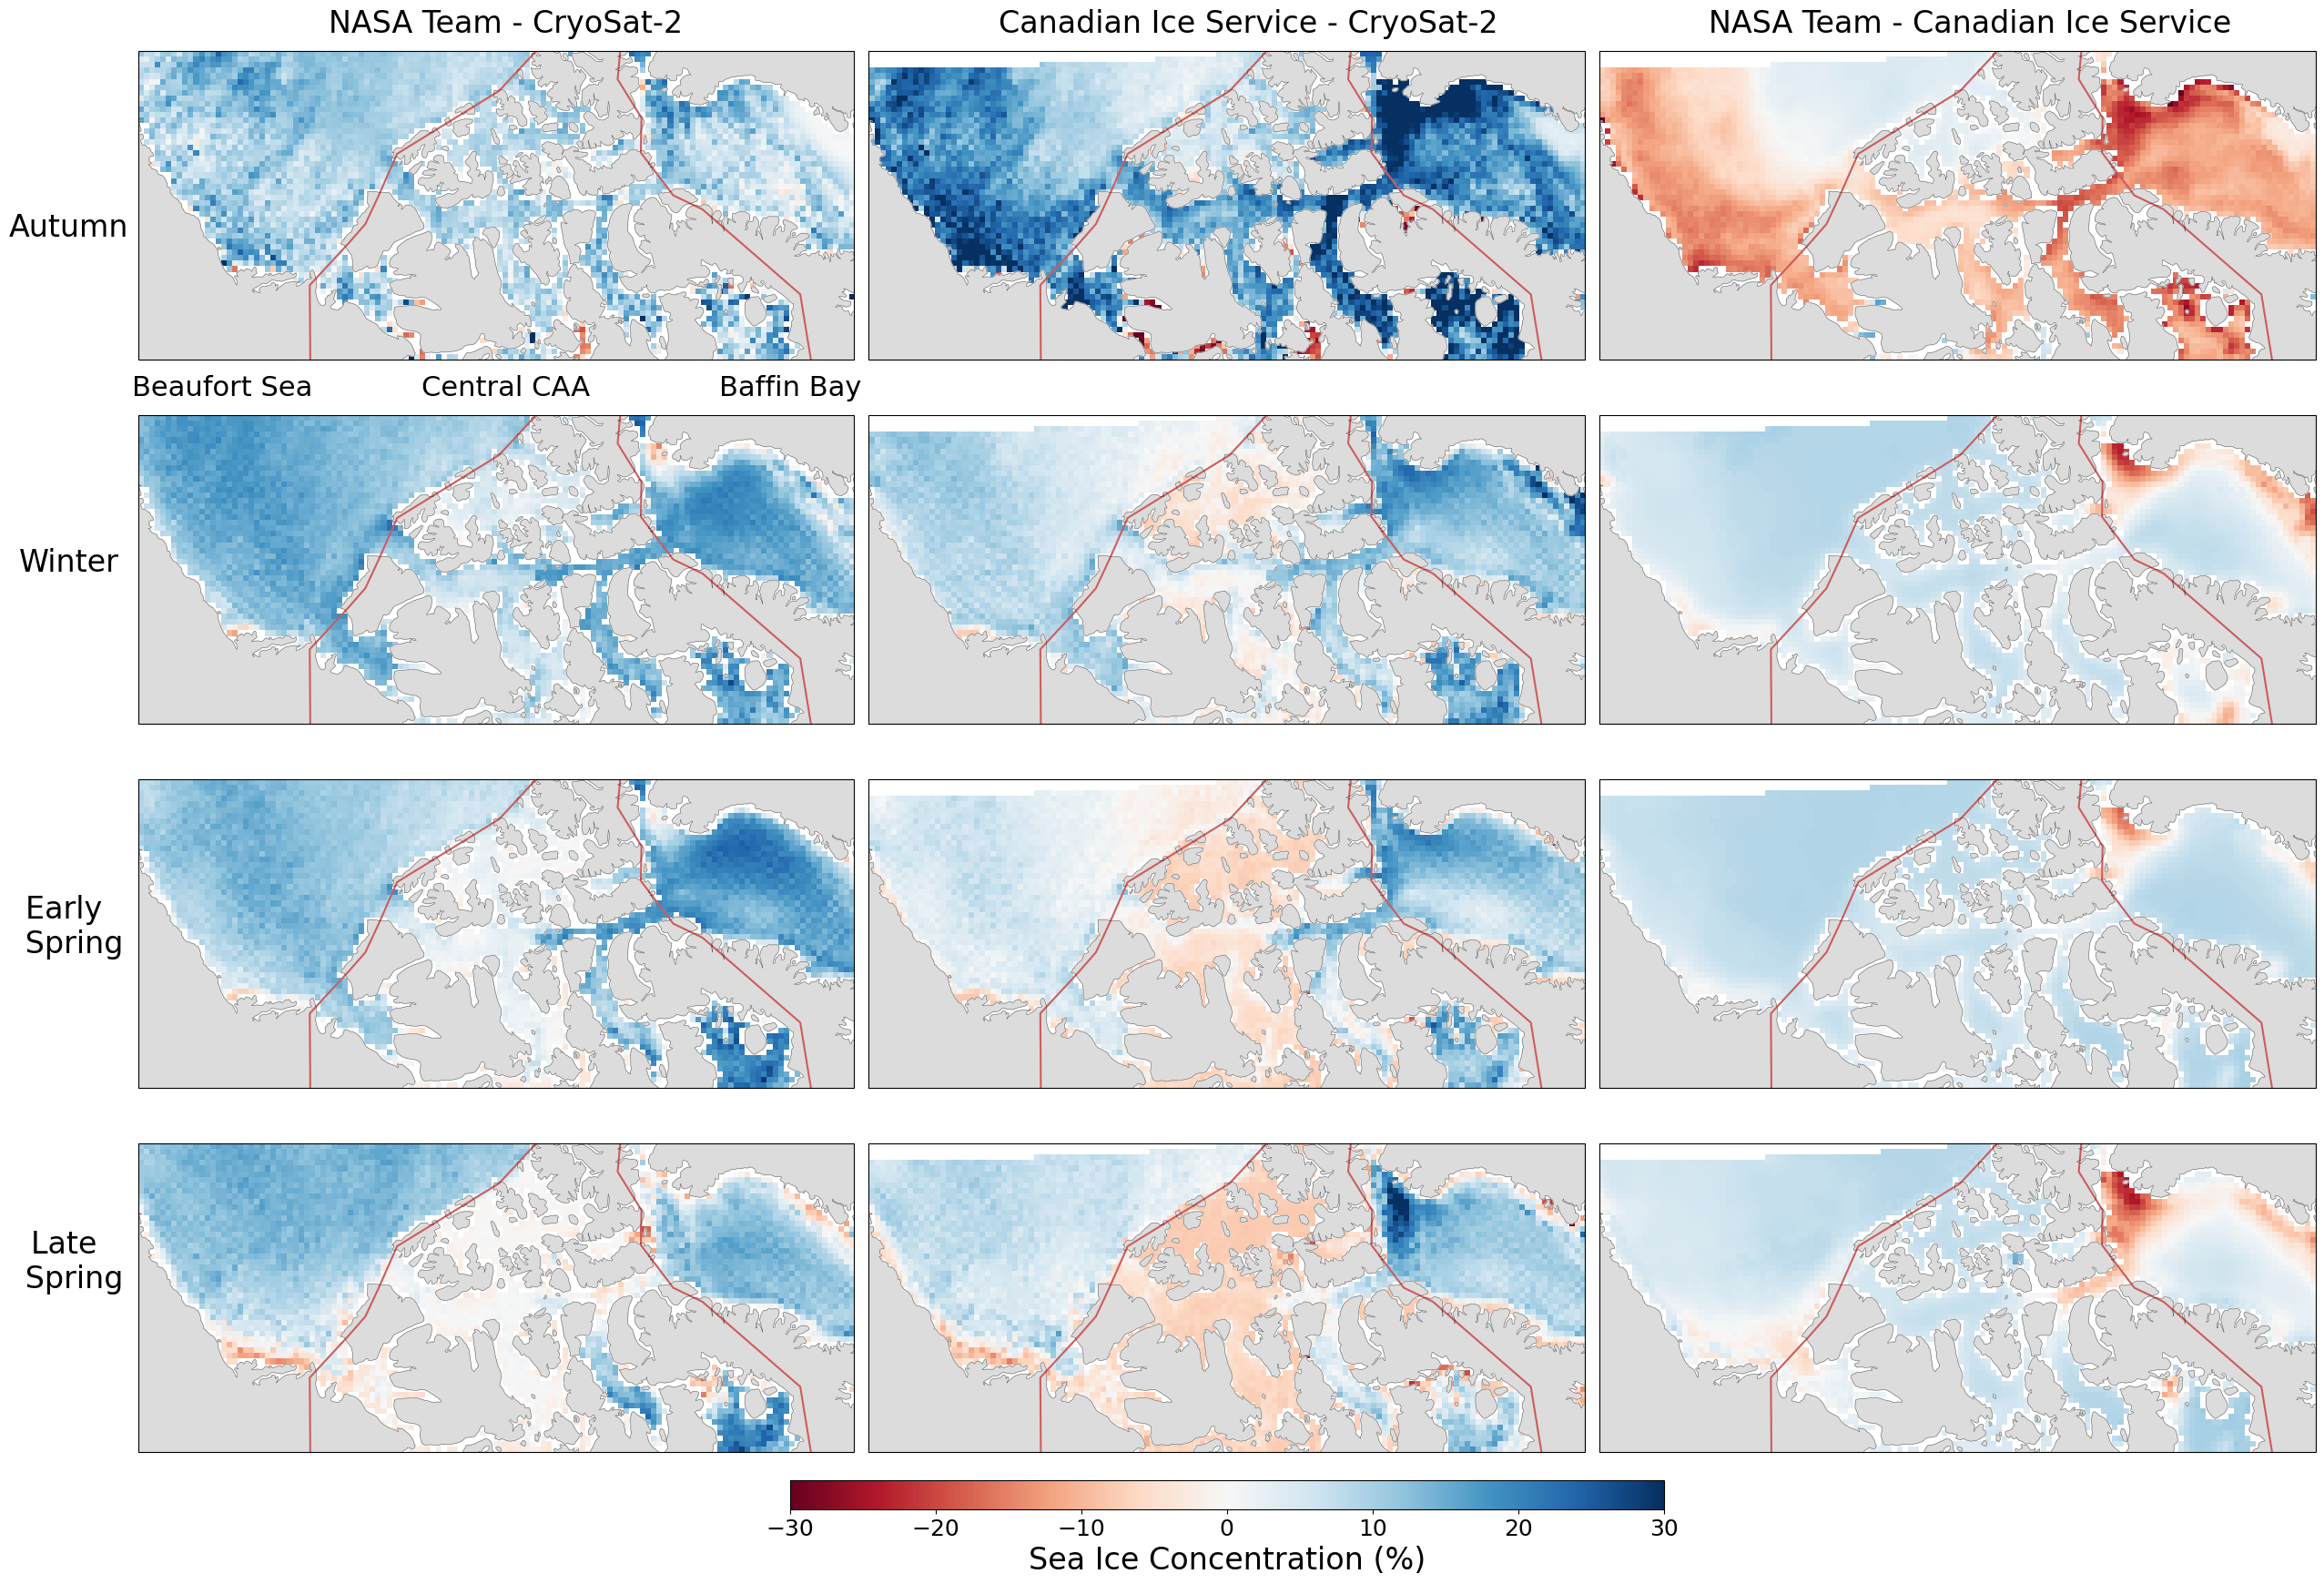

In [7]:
# Plot the arrays

# Plot the figure

fig, axs = plt.subplots(4, 3, figsize=(24,16), subplot_kw={'projection':map_projection}, layout='constrained')

for i, season_name in enumerate(seasons.keys()):
    # Plot CS2
    plotting_diff_maps_grid(map_projection, new_x_centre, new_y_centre, teamcs2_regions_diffs[season_name],
                           cmap='RdBu', vmin=-30, vmax=30, ax=axs[i, 0])

    # Plot Team
    pcm = plotting_diff_maps_grid(map_projection, new_x_edge, new_y_edge, ciscs2_regions_diffs[season_name],
                           cmap='RdBu', vmin=-30, vmax=30, ax=axs[i, 1])

    # Plot CIS
    plotting_diff_maps_grid(map_projection, new_x_edge, new_y_edge, teamcis_regions_diffs[season_name],
                           cmap='RdBu', vmin=-30, vmax=30, ax=axs[i, 2])

#Â Add labels
fig.text(-0.03, 0.86, 'Autumn', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)
fig.text(-0.03, 0.63, 'Winter', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)
fig.text(-0.03, 0.38, 'Early \n Spring', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)
fig.text(-0.03, 0.15, 'Late \n Spring', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)

fig.text(0.17, 1, 'NASA Team - CryoSat-2', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)
fig.text(0.51, 1, 'Canadian Ice Service - CryoSat-2', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)
fig.text(0.84, 1, 'NASA Team - Canadian Ice Service', va='center', ha='center', 
         rotation='horizontal', fontsize=24, transform=fig.transFigure)

fig.text(0.04, 0.75, 'Beaufort Sea', va='center', ha='center', 
         rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(0.17, 0.75, 'Central CAA', va='center', ha='center', 
        rotation='horizontal', fontsize=22, transform=fig.transFigure)
fig.text(0.3, 0.75, 'Baffin Bay', va='center', ha='center', 
        rotation='horizontal', fontsize=22, transform=fig.transFigure)

# Plot colorbar underneath axis
cbar_ax = fig.add_axes([0.3, -0.02, 0.4, 0.02])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Sea Ice Concentration (%)', fontsize=24)

plt.show()

